In [1]:
# !pip install tensorflow==1.15.0

In [9]:
# %tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rd
device_name = tf.test.gpu_device_name()
print(device_name)
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))
tfd = tf.contrib.distributions
print(tf.__version__)


1.15.0


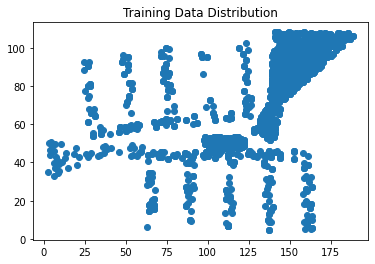

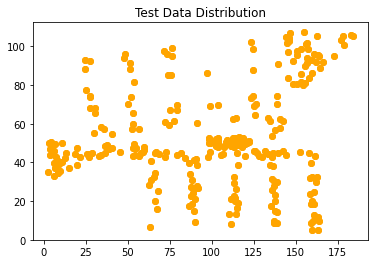

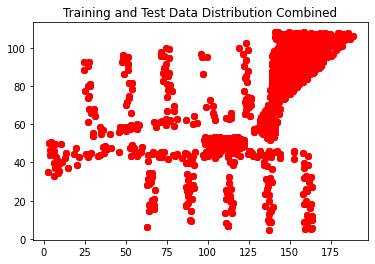

In [3]:
train_dataset = np.load("FireEvac_train_set.npy")
test_dataset = np.load("FireEvac_test_set.npy")
plt.title('Training Data Distribution')
plt.scatter(train_dataset[:, 0], train_dataset[:, 1])
plt.show()
plt.title('Test Data Distribution')
plt.scatter(test_dataset[:, 0], test_dataset[:, 1], c = "orange")
plt.show()
plt.title('Training and Test Data Distribution Combined')
plt.scatter(np.concatenate((train_dataset[:, 0], test_dataset[:, 0])), np.concatenate((train_dataset[:, 1], test_dataset[:, 1])), c='red')
plt.show()

In [4]:
# Normalise data with min max normalisation 
xmin = np.minimum(train_dataset.min(0), test_dataset.min(0))
xmax = np.maximum(train_dataset.max(0), test_dataset.min(0))
test_dataset_norm = 2*(test_dataset-xmin)/(xmax-xmin)-1
train_dataset_norm = 2*(train_dataset-xmin)/(xmax-xmin)-1

In [5]:
# Define architecture of the neural networks

# Encoder/posterior: q(z|x) 
def make_encoder(data, code_size):
  # First hidden layer with 256 neurons and relu activation faunction 
  x = tf.layers.dense(data, 256, tf.nn.relu)
  # Second hidden layer with 256 neurons and relu activation faunction
  x = tf.layers.dense(x, 256, tf.nn.relu)

 
  # ... the mean ...
  loc = tf.layers.dense(x, code_size)
  # ... and the diagonal of the scale matrix which is used for the covarinace matrix (cov=scale*scale.T) ... 
  # ... further it can be called the standard deviation 
  scale = tf.layers.dense(x, code_size, tf.nn.softplus)
  # Finally we return the posterior probability distribution in form of a multivariate normal distribution with diagonal covariance matrix  
  return tfd.MultivariateNormalDiag(loc, scale)

# Prior:p(z)
def make_prior(code_size):
  # Zero mean
  loc = tf.zeros(code_size)
  # Identity matrix as standard deveation and consequently covariance matrix 
  scale = tf.ones(code_size)
  # Return prior as code_size dimensional normal distribution with diagonal covariance matrix
  return tfd.MultivariateNormalDiag(loc, scale)

# Decoder/likelihood: p(x|z) 
def make_decoder(code, data_shape):
  # Code is latent variable z
  x = code
  # First hidden layer with 256 neurons and relu activation faunction 
  x = tf.layers.dense(x, 256, tf.nn.relu)
  # Second hidden layer with 256 neurons and relu activation faunction
  x = tf.layers.dense(x, 256, tf.nn.relu)
  # Output layer for the mean values producing a long vector with the dimensonalty equal to the number of pixels
  logit = tf.layers.dense(x, data_shape[0])
  # Using only one layer with output shape of the long picture vector and relu activation function since the standard deviation is always positive 
  standard_deviation = tf.layers.dense(x, data_shape[0], tf.nn.softplus)

  # Return likelihood as picture size dimensional normal distribution with diagonal covariance matrix
  return  tfd.MultivariateNormalDiag(logit, standard_deviation)#tfd.Independent(tfd.MultivariateNormalDiag(logit, standard_deviation), 2)


In [6]:
# Initialise the data tensor as placeholder
data = tf.placeholder(tf.float32, [None, 2])

# Create a template of the encoder and decoder such that the parameters stay the same
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model with latent variable 2
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# Define the loss
likelihood = make_decoder(code, [2]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
# Set up the Adam optimizer with learning rate 0.001
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

# Generate encoded sample picure in latent sapce and return decoded mean  
samples_generated = make_decoder(prior.sample(1000), [2]).sample()

# Generate encoded sample picure in latent sapce and return decoded mean 
samples_reconstructed = make_decoder(make_encoder(data[0:250, :], code_size=2).mean(), [2]).mean()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -1.8154801


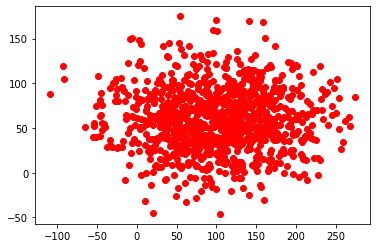

Epoch 1 elbo -1.985106


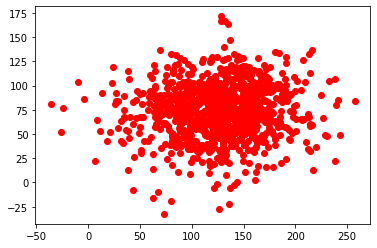

Epoch 2 elbo -2.1832862
Epoch 3 elbo -2.2156763
Epoch 4 elbo -2.4385583
Epoch 5 elbo -2.1946251
Epoch 6 elbo -2.2996638
Epoch 7 elbo -2.3558173
Epoch 8 elbo -2.1734931
Epoch 9 elbo -2.1381571
Epoch 10 elbo -2.1213048
Epoch 11 elbo -1.9987311
Epoch 12 elbo -2.0636408
Epoch 13 elbo -1.9348875
Epoch 14 elbo -1.9156514
Epoch 15 elbo -1.8138609
Epoch 16 elbo -1.8584863
Epoch 17 elbo -1.8078579
Epoch 18 elbo -1.8345847
Epoch 19 elbo -1.8933557
Epoch 20 elbo -1.9087985
Epoch 21 elbo -1.8923228
Epoch 22 elbo -1.8761379
Epoch 23 elbo -1.8149382
Epoch 24 elbo -1.9170569
Epoch 25 elbo -1.8273304
Epoch 26 elbo -1.9225852
Epoch 27 elbo -1.8693168
Epoch 28 elbo -1.8216337
Epoch 29 elbo -1.8984727
Epoch 30 elbo -1.8159428
Epoch 31 elbo -1.9364986
Epoch 32 elbo -1.780268
Epoch 33 elbo -1.7431189
Epoch 34 elbo -1.8653873
Epoch 35 elbo -1.8595314
Epoch 36 elbo -1.7821999
Epoch 37 elbo -1.9886314
Epoch 38 elbo -1.8907717
Epoch 39 elbo -1.8404276
Epoch 40 elbo -1.8350626
Epoch 41 elbo -1.8198266
Epoch 42 

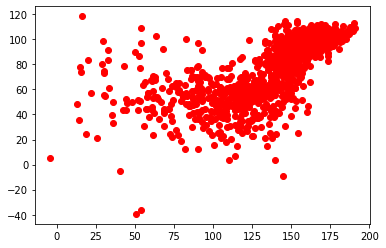

Epoch 51 elbo -1.7933646
Epoch 52 elbo -1.9915446
Epoch 53 elbo -1.9232523
Epoch 54 elbo -1.7558266
Epoch 55 elbo -1.8984997
Epoch 56 elbo -1.8428402
Epoch 57 elbo -1.9588507
Epoch 58 elbo -1.7692802
Epoch 59 elbo -1.9838775
Epoch 60 elbo -1.8282526
Epoch 61 elbo -1.8949184
Epoch 62 elbo -1.782418
Epoch 63 elbo -1.8843459
Epoch 64 elbo -1.7640718
Epoch 65 elbo -1.7103784
Epoch 66 elbo -1.844557
Epoch 67 elbo -1.9885501
Epoch 68 elbo -1.7132314
Epoch 69 elbo -1.8642414
Epoch 70 elbo -1.8355111
Epoch 71 elbo -1.7086318
Epoch 72 elbo -1.8558441
Epoch 73 elbo -1.8178705
Epoch 74 elbo -1.7415334
Epoch 75 elbo -1.7799965
Epoch 76 elbo -1.780025
Epoch 77 elbo -1.7952026
Epoch 78 elbo -1.8653977
Epoch 79 elbo -1.8197589
Epoch 80 elbo -1.7783309
Epoch 81 elbo -1.9206954
Epoch 82 elbo -1.7521173
Epoch 83 elbo -1.759389
Epoch 84 elbo -1.7704508
Epoch 85 elbo -1.7683126
Epoch 86 elbo -1.828373
Epoch 87 elbo -1.7389543
Epoch 88 elbo -1.7309499
Epoch 89 elbo -1.7600541
Epoch 90 elbo -1.8707882
Epoch

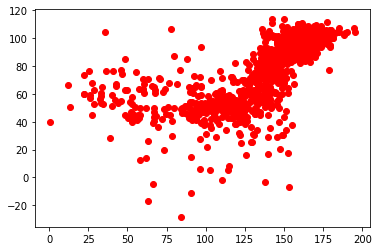

Epoch 101 elbo -1.732115
Epoch 102 elbo -1.77072
Epoch 103 elbo -1.8164809
Epoch 104 elbo -1.7735176
Epoch 105 elbo -1.8483024
Epoch 106 elbo -1.7325419
Epoch 107 elbo -1.7044526
Epoch 108 elbo -1.8007141
Epoch 109 elbo -1.7324193
Epoch 110 elbo -1.7316256
Epoch 111 elbo -1.7722199
Epoch 112 elbo -1.8729789
Epoch 113 elbo -1.7579409
Epoch 114 elbo -1.736232
Epoch 115 elbo -1.6153271
Epoch 116 elbo -1.7744373
Epoch 117 elbo -1.780791
Epoch 118 elbo -1.9062517
Epoch 119 elbo -1.8090317
Epoch 120 elbo -1.7773159
Epoch 121 elbo -1.8263041
Epoch 122 elbo -1.7354714
Epoch 123 elbo -1.7115263
Epoch 124 elbo -1.6794357
Epoch 125 elbo -1.7317163
Epoch 126 elbo -1.7274398
Epoch 127 elbo -1.649671
Epoch 128 elbo -1.7965238
Epoch 129 elbo -1.8225443
Epoch 130 elbo -1.6560718
Epoch 131 elbo -1.8188442
Epoch 132 elbo -1.7534767
Epoch 133 elbo -1.7560661
Epoch 134 elbo -1.8869743
Epoch 135 elbo -1.7031068
Epoch 136 elbo -1.7989514
Epoch 137 elbo -2.7338831
Epoch 138 elbo -1.8535237
Epoch 139 elbo -1.

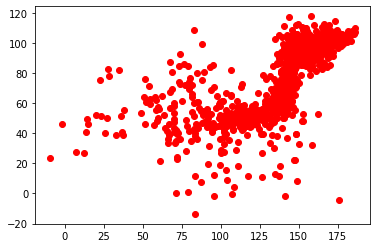

Epoch 251 elbo -1.661483
Epoch 252 elbo -1.7274331
Epoch 253 elbo -1.6970726
Epoch 254 elbo -1.6817095
Epoch 255 elbo -1.9826375
Epoch 256 elbo -1.6353604
Epoch 257 elbo -1.6279845
Epoch 258 elbo -1.8167269
Epoch 259 elbo -1.8878833
Epoch 260 elbo -1.7841322
Epoch 261 elbo -1.6286047
Epoch 262 elbo -1.8125427
Epoch 263 elbo -1.7969605
Epoch 264 elbo -1.6711189
Epoch 265 elbo -1.5588658
Epoch 266 elbo -1.5990753
Epoch 267 elbo -1.6954088
Epoch 268 elbo -1.686208
Epoch 269 elbo -1.5816004
Epoch 270 elbo -1.8670609
Epoch 271 elbo -1.6739527
Epoch 272 elbo -1.7985045
Epoch 273 elbo -1.7227771
Epoch 274 elbo -1.8790735
Epoch 275 elbo -1.729844
Epoch 276 elbo -1.8164724
Epoch 277 elbo -1.6989968
Epoch 278 elbo -1.6988612
Epoch 279 elbo -1.7172501
Epoch 280 elbo -1.6337695
Epoch 281 elbo -1.6190898
Epoch 282 elbo -1.6361564
Epoch 283 elbo -1.646726
Epoch 284 elbo -1.6619518
Epoch 285 elbo -1.5748825
Epoch 286 elbo -1.6308742
Epoch 287 elbo -1.7504421
Epoch 288 elbo -1.6125315
Epoch 289 elbo -

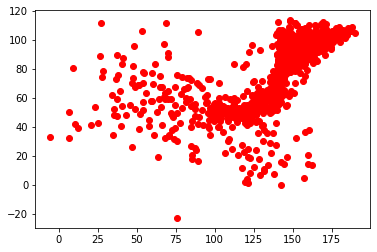

Epoch 1001 elbo -1.5757247
Epoch 1002 elbo -1.6819013
Epoch 1003 elbo -1.5720574
Epoch 1004 elbo -1.5572618
Epoch 1005 elbo -1.7671773
Epoch 1006 elbo -1.5656387
Epoch 1007 elbo -1.4599345
Epoch 1008 elbo -1.45479
Epoch 1009 elbo -1.5461802
Epoch 1010 elbo -1.4891937
Epoch 1011 elbo -1.479603
Epoch 1012 elbo -1.6155094
Epoch 1013 elbo -1.5024403
Epoch 1014 elbo -1.5826406
Epoch 1015 elbo -1.5323493
Epoch 1016 elbo -1.4882131
Epoch 1017 elbo -1.5154132
Epoch 1018 elbo -1.6527289
Epoch 1019 elbo -1.5265086
Epoch 1020 elbo -1.5766652
Epoch 1021 elbo -1.532353
Epoch 1022 elbo -1.4381515
Epoch 1023 elbo -1.6678387
Epoch 1024 elbo -1.4634196
Epoch 1025 elbo -1.6159804
Epoch 1026 elbo -1.5715091
Epoch 1027 elbo -1.7241013
Epoch 1028 elbo -1.5187312
Epoch 1029 elbo -1.4793273
Epoch 1030 elbo -1.6732019
Epoch 1031 elbo -1.5361432
Epoch 1032 elbo -1.6580721
Epoch 1033 elbo -1.5232477
Epoch 1034 elbo -1.4658401
Epoch 1035 elbo -1.5894529
Epoch 1036 elbo -1.4537274
Epoch 1037 elbo -1.5171549
Epoch

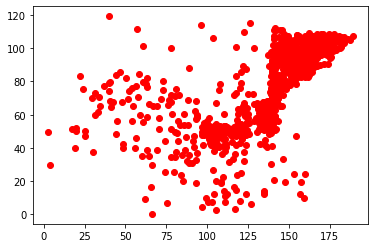

Epoch 2001 elbo -1.4874711
Epoch 2002 elbo -1.4060205
Epoch 2003 elbo -1.3716196
Epoch 2004 elbo -1.3354961
Epoch 2005 elbo -1.5033156
Epoch 2006 elbo -1.3771688
Epoch 2007 elbo -1.5228317
Epoch 2008 elbo -1.3673245
Epoch 2009 elbo -1.3047476
Epoch 2010 elbo -1.3943111
Epoch 2011 elbo -1.4236685
Epoch 2012 elbo -1.3798815
Epoch 2013 elbo -1.4205052
Epoch 2014 elbo -1.414243
Epoch 2015 elbo -1.378643
Epoch 2016 elbo -1.4566703
Epoch 2017 elbo -1.4443151
Epoch 2018 elbo -1.398616
Epoch 2019 elbo -1.4570576
Epoch 2020 elbo -1.5009991
Epoch 2021 elbo -1.2614194
Epoch 2022 elbo -1.3627439
Epoch 2023 elbo -1.471655
Epoch 2024 elbo -1.5159512
Epoch 2025 elbo -1.4425184
Epoch 2026 elbo -1.401987
Epoch 2027 elbo -1.5067803
Epoch 2028 elbo -1.655274
Epoch 2029 elbo -1.4844184
Epoch 2030 elbo -1.3745816
Epoch 2031 elbo -1.3306442
Epoch 2032 elbo -1.3046858
Epoch 2033 elbo -1.4472811
Epoch 2034 elbo -1.3704531
Epoch 2035 elbo -1.4757438
Epoch 2036 elbo -1.5323437
Epoch 2037 elbo -1.4961103
Epoch 2

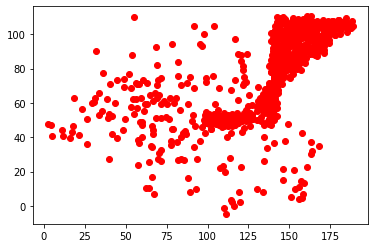

Epoch 3001 elbo -1.2985792
Epoch 3002 elbo -1.4907978
Epoch 3003 elbo -1.3194039
Epoch 3004 elbo -1.3266716
Epoch 3005 elbo -1.4708757
Epoch 3006 elbo -1.3736243
Epoch 3007 elbo -1.32786
Epoch 3008 elbo -1.4732704
Epoch 3009 elbo -1.3747932
Epoch 3010 elbo -1.3293846
Epoch 3011 elbo -1.2279319
Epoch 3012 elbo -1.3561474
Epoch 3013 elbo -1.3931412
Epoch 3014 elbo -1.2837824
Epoch 3015 elbo -1.341215
Epoch 3016 elbo -1.2952896
Epoch 3017 elbo -1.1968752
Epoch 3018 elbo -1.3252207
Epoch 3019 elbo -1.2979422
Epoch 3020 elbo -1.3939079
Epoch 3021 elbo -1.2662773
Epoch 3022 elbo -1.2675064
Epoch 3023 elbo -1.3422883
Epoch 3024 elbo -1.3606621
Epoch 3025 elbo -1.3988373
Epoch 3026 elbo -1.3807534
Epoch 3027 elbo -1.3152541
Epoch 3028 elbo -1.3437638
Epoch 3029 elbo -1.3922435
Epoch 3030 elbo -1.3433769
Epoch 3031 elbo -1.2678766
Epoch 3032 elbo -1.4155353
Epoch 3033 elbo -1.2836812
Epoch 3034 elbo -1.4573798
Epoch 3035 elbo -1.3450843
Epoch 3036 elbo -1.234282
Epoch 3037 elbo -1.2967007
Epoch

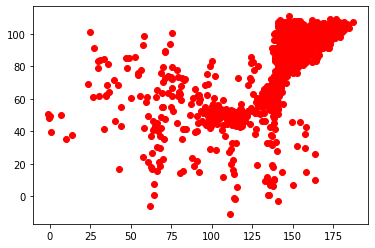

Epoch 4001 elbo -1.1561506
Epoch 4002 elbo -1.2406745
Epoch 4003 elbo -1.2288392
Epoch 4004 elbo -1.2150238
Epoch 4005 elbo -1.4605204
Epoch 4006 elbo -1.2819166
Epoch 4007 elbo -1.2488102
Epoch 4008 elbo -1.230472
Epoch 4009 elbo -1.3361533
Epoch 4010 elbo -1.4780984
Epoch 4011 elbo -1.5026776
Epoch 4012 elbo -1.575345
Epoch 4013 elbo -1.5413722
Epoch 4014 elbo -1.4366331
Epoch 4015 elbo -1.228873
Epoch 4016 elbo -1.19017
Epoch 4017 elbo -1.2491213
Epoch 4018 elbo -1.4338033
Epoch 4019 elbo -1.2690575
Epoch 4020 elbo -1.2556572
Epoch 4021 elbo -1.3618916
Epoch 4022 elbo -1.3139269
Epoch 4023 elbo -1.3082547
Epoch 4024 elbo -1.2268144
Epoch 4025 elbo -1.1653113
Epoch 4026 elbo -1.1449524
Epoch 4027 elbo -1.2211312
Epoch 4028 elbo -1.2298555
Epoch 4029 elbo -1.3933449
Epoch 4030 elbo -1.2817317
Epoch 4031 elbo -1.2703117
Epoch 4032 elbo -1.2294699
Epoch 4033 elbo -1.4520173
Epoch 4034 elbo -1.406052
Epoch 4035 elbo -1.3104869
Epoch 4036 elbo -1.240959
Epoch 4037 elbo -1.2813083
Epoch 40

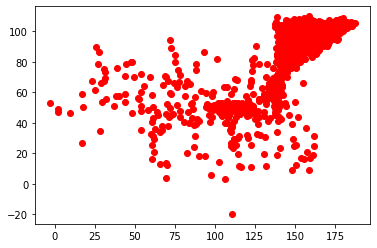

Epoch 5001 elbo -1.2182101
Epoch 5002 elbo -1.2340817
Epoch 5003 elbo -1.2580764
Epoch 5004 elbo -1.2769848
Epoch 5005 elbo -1.2192031
Epoch 5006 elbo -1.2481902
Epoch 5007 elbo -1.242345
Epoch 5008 elbo -1.2946875
Epoch 5009 elbo -1.3082887
Epoch 5010 elbo -1.2477443
Epoch 5011 elbo -1.2619908
Epoch 5012 elbo -1.1827492
Epoch 5013 elbo -1.3050345
Epoch 5014 elbo -1.4477543
Epoch 5015 elbo -1.5647571
Epoch 5016 elbo -1.2111847
Epoch 5017 elbo -1.2085098
Epoch 5018 elbo -1.1481754
Epoch 5019 elbo -1.2013155
Epoch 5020 elbo -1.2057422
Epoch 5021 elbo -1.1692773
Epoch 5022 elbo -1.2515388
Epoch 5023 elbo -1.2226647
Epoch 5024 elbo -1.2090256
Epoch 5025 elbo -1.284467
Epoch 5026 elbo -1.6760182
Epoch 5027 elbo -1.5133681
Epoch 5028 elbo -1.4974451
Epoch 5029 elbo -1.2396312
Epoch 5030 elbo -1.2397509
Epoch 5031 elbo -1.2953793
Epoch 5032 elbo -1.2787077
Epoch 5033 elbo -1.176168
Epoch 5034 elbo -1.1893249
Epoch 5035 elbo -1.3966743
Epoch 5036 elbo -1.396278
Epoch 5037 elbo -1.4120032
Epoch

KeyboardInterrupt: ignored

In [7]:
# Create frame for the plot of the reconstructed pictures and latent space representation
#fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(50, 20))
# Set training parameters
batch_size = int(100)
# Initialise vectors which store some training data
elbo_history = np.array([0, np.inf])
num_epoch = 7000
plot_epoch = [0,1,50,100,250,1000,2000,3000,4000,5000]
# Start training
with tf.train.MonitoredSession() as sess:
  # Train until the loss does not change remarkeable
  for epoch in range(num_epoch):
    # Put normalised test data in a dictionary 
    feed = {data: test_dataset_norm}
    # Compute the Loss/elbo and the latent code from posterior encoder of the test data and compute the decoded mean (picture) of randomly from the prior sampled latent coordinates   
    test_elbo, test_codes, test_samples_generated = sess.run([elbo, code, samples_generated], feed)
    # Store the history of test loss/elbo
    elbo_history = np.append(elbo_history, np.array([test_elbo]))
    # Print the Epoch and the test loss/elbo
    print('Epoch', epoch, 'elbo', test_elbo)

    # Plot latent space the 15 generated pictures for epoch 1, 5, 25, 50
    if epoch in plot_epoch:
        plt.figure()
        tsg_unnorm = ((test_samples_generated+1)*(xmax-xmin)/2)+xmin
        plt.scatter(tsg_unnorm[:, 0], tsg_unnorm[:, 1], c='red')
        plt.savefig('fire_evac_generated_'+str(epoch)+'.pdf')
        plt.show()

    # Store the number of training samples (60.000) 
    number_train_data = train_dataset_norm.shape[0]
    # Rondomly sample 60.000 indices
    batch = rd.sample(range(number_train_data), number_train_data)
    # Compute the total number of batches
    batch_number = int(np.floor(number_train_data/batch_size))

    # Go through all batches
    for iter in range(batch_number):
      # Construct the batch as dictionary from the training data 
      feed = {data: train_dataset_norm[batch[iter*batch_size:((iter+1)*batch_size)-1]]}
      # Compute one update step of the network parameter
      sess.run(optimize, feed)

    #Increase the epoch counter variable   
    epoch += 1


plt.figure()
tsg_unnorm = ((test_samples_generated+1)*(xmax-xmin)/2)+xmin
plt.scatter(tsg_unnorm[:, 0], tsg_unnorm[:, 1], c='red')
plt.show()
plt.savefig('task4.png', dpi=400, transparent=True, bbox_inches='tight')

In [7]:
from VaderePedestrianAddition import add_pedestrians_scenario
# Load generated vector from p(x)
pedestrian_position_sampled = np.load('pedestrian_position_sampled.npy')
pedestrian_position_sampled=np.float64(pedestrian_position_sampled)
# Add pedestrians to Vadere
add_pedestrians_scenario(pedestrian_position_sampled[0:99, 0], pedestrian_position_sampled[0:99, 1])

In [8]:
# Count as we reach the critical number of pedestrians
coordinates = pedestrian_position_sampled
ped_critical = 0
for  i, coord in enumerate(coordinates):
    if 130 < coord[0] and coord[0] < 150 and 50 < coord[1] and coord[1] < 70:
        ped_critical += 1
    if ped_critical > 100:
        print(i)
        break

1052
